In [ ]:
# Notebook settings
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

# SpikeInterface pipeline for Movshon Lab - OpenEphys

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pytz

import spikeextractors as se
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc
import spikewidgets as sw

In [ ]:
%matplotlib notebook

## 1) Load recordings, compute LFP, and inspect signals

In [ ]:
# Data files directory
# dir_path = Path('/home/luiz/storage/taufferconsulting/client_ben/project_movshon/movshon_data/oephys')
# dir_path = Path('/home/luiz/storage/taufferconsulting/client_ben/project_movshon/movshon_data/expo/exampledata/expo_openephys/m666l3#7/openephys')
dir_path = Path('/Users/abuccino/Documents/Data/catalyst/movshon/m666l3#7/openephys')

# Spikeinterface directory
dir_spikeinterface = dir_path / "spikeinterface"
dir_spikeinterface.mkdir(parents=True, exist_ok=True)
print(dir_spikeinterface)

# Create recording extractor
recording_0 = se.OpenEphysRecordingExtractor(folder_path=dir_path)

# Load probe info from .prb file
probe_file = Path("..") / "probe_files" / 'A32_ACDC.prb'
recording = recording_0.load_probe_file(probe_file=probe_file)

print()
print(f"Num channels: {recording.get_num_channels()}")
print(f"Sampling rate: {recording.get_sampling_frequency()}")
print(f"Duration (s): {recording.get_num_frames() / recording.get_sampling_frequency()}")

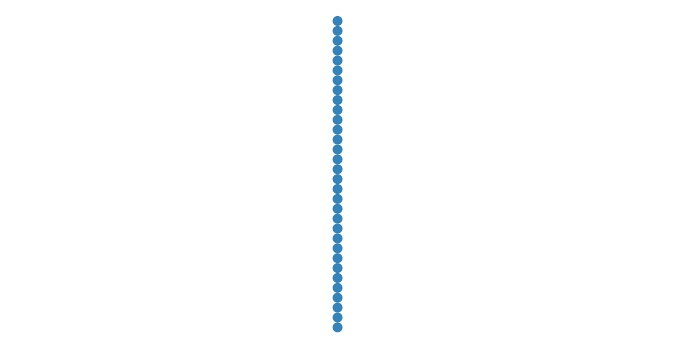

In [47]:
fig = plt.figure(figsize=(12, 6))
sw.plot_electrode_geometry(recording, figure=fig)

### Compute LFP

In [5]:
freq_min_lfp = 1
freq_max_lfp = 300
freq_resample_lfp = 1000.

# Apply bandpass filter
recording_lfp = st.preprocessing.bandpass_filter(
    recording=recording, 
    freq_min=freq_min_lfp, 
    freq_max=freq_max_lfp
)

# Resample lfp
recording_lfp = st.preprocessing.resample(
    recording=recording_lfp, 
    resample_rate=freq_resample_lfp,
)

print(f"Sampling frequency Raw: {recording.get_sampling_frequency()}")
print(f"Sampling frequency LF: {recording_lfp.get_sampling_frequency()}")   

### Inspect signals

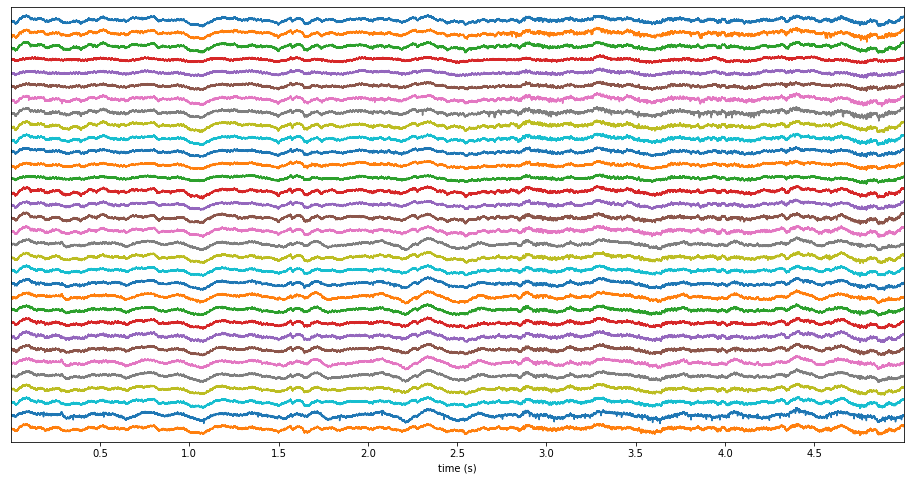

In [22]:
fig = plt.figure(figsize=(16, 8))
w_ts_raw = sw.plot_timeseries(recording, trange=[0, 5], figure=fig)

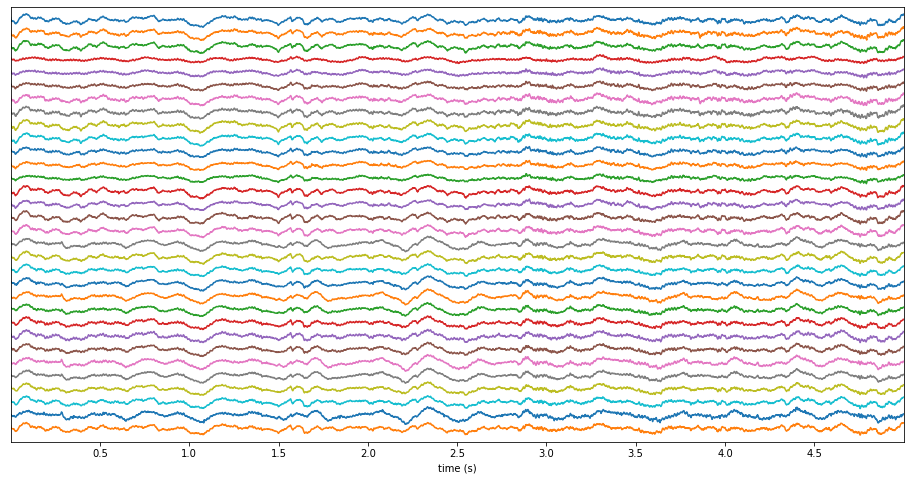

In [23]:
fig = plt.figure(figsize=(16, 8))
w_ts_lf = sw.plot_timeseries(recording_lfp, trange=[0, 5], figure=fig)

## 2) Pre-processing
- Filters
- Common-reference removal
- Remove bad channels
- Remove stimulation artifacts

Ref: https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_1_preprocessing.html#preprocessing-tutorial

In [8]:
apply_filter = True
apply_cmr = True
freq_min_hp = 300
freq_max_hp = 3000

In [9]:
# Filtered recordings
if apply_filter:
    recording_processed = st.preprocessing.bandpass_filter(recording, freq_min=freq_min_hp, freq_max=freq_max_hp)
else:
    recording_processed = recording

if apply_cmr:
    recording_processed = st.preprocessing.common_reference(recording_processed)
    
# Stub recording for fast testing; set to False for running processing pipeline on entire data
stub_test = True
nsec_stub = 30
subr_ids = [i + 1 for i in range(31)]
if stub_test:
    recording_processed = se.SubRecordingExtractor(
        parent_recording=recording_processed, 
        channel_ids=subr_ids,
        end_frame=int(nsec_stub*recording_processed.get_sampling_frequency())
    )
    recording_lfp = se.SubRecordingExtractor(recording_lfp, end_frame=int(nsec_stub*recording_lfp.get_sampling_frequency()))
    
print(f"Original signal length: {recording.get_num_frames()}")
print(f"Processed signal length: {recording_processed.get_num_frames()}")

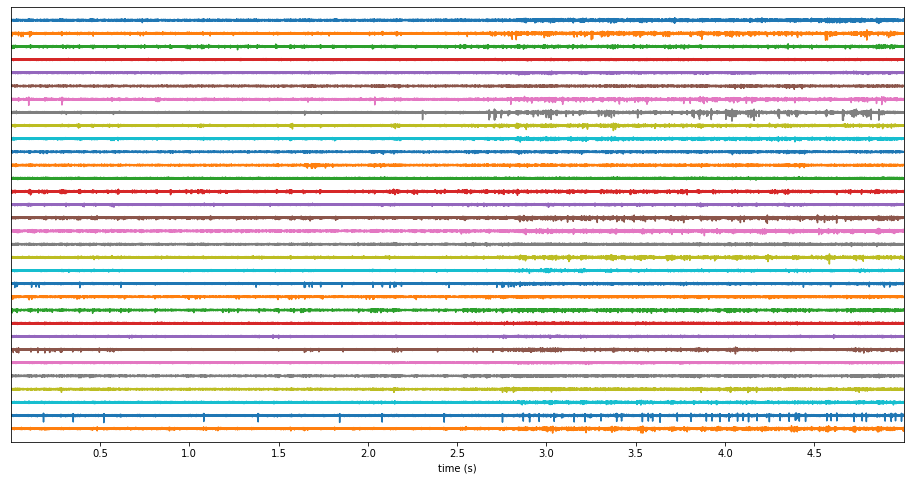

In [24]:
fig = plt.figure(figsize=(16, 8))
w_ts_processed = sw.plot_timeseries(recording_processed, trange=[0, 5], figure=fig)

## 3) Run spike sorters

Ref: https://spikeinterface.readthedocs.io/en/latest/sortersinfo.html

In [11]:
ss.installed_sorters()

['herdingspikes', 'klusta']

In [12]:
sorter_list = ['klusta', 'herdingspikes']
sorter_params = dict()

# Inspect sorter-specific parameters and defaults
for sorter in sorter_list:
    print(f"\n\n{sorter} params description:\n")
    pprint(ss.get_params_description(sorter))
    print("Default params:")
    sorter_params[sorter] = ss.get_default_params(sorter)
    pprint(sorter_params)
    print()

klusta params description:
{'adjacency_radius': 'Radius in um to build channel neighborhood ',
 'chunk_mb': 'Chunk size in Mb for saving to binary format (default 500Mb)',
 'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the '
                'sign of the spikes in the recording',
 'extract_s_after': 'Number of samples to cut out after the peak',
 'extract_s_before': 'Number of samples to cut out before the peak',
 'n_features_per_channel': 'Number of PCA features per channel',
 'n_jobs_bin': 'Number of jobs for saving to binary format (Default 1)',
 'num_starting_clusters': 'Number of initial clusters',
 'pca_n_waveforms_max': 'Maximum number of waveforms for PCA',
 'threshold_strong_std_factor': 'Strong threshold for spike detection',
 'threshold_weak_std_factor': 'Weak threshold for spike detection'}
Default params:
{'klusta': {'adjacency_radius': None,
            'chunk_mb': 500,
            'detect_sign': -1,
            'extract_s_after': 32,
           

In [15]:
# Choose which recording to use for sorting
rec_to_sort = recording_processed #se.CacheRecordingExtractor(recording_processed, "cache.dat")

# Sorting parameters - Herdingspikes
sorter_params['herdingspikes'] = {
    'filter': False,
    'filter_duplicates': False,
    'probe_neighbor_radius': 200,
}

sorting_outputs = {}
for sorter_name in sorter_list:
    # run sorter
    sorting = ss.run_sorter(
        sorter_name_or_class=sorter_name, 
        recording=rec_to_sort, 
        output_folder=dir_spikeinterface / "si_output" / sorter_name,
        **sorter_params[sorter_name], 
        verbose=False
    )
    sorting_outputs[sorter_name] = sorting
    
for sorter_name in sorter_list:
    print(f'Sorter {sorter_name} identified {len(sorting_outputs[sorter_name].get_unit_ids())} units')

Sorter klusta identified 59 units
Sorter herdingspikes identified 24 units


## 4) Post-processing
- Compute spike waveforms
- Compute unit templates
- Compute extracellular features

Ref: https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_2_postprocessing.html

In [16]:
# Post-processing params
postprocessing_params = st.postprocessing.get_common_params()
pprint(postprocessing_params)

In [17]:
# (optional) change parameters
postprocessing_params['max_spikes_per_unit'] = 1000  # with None, all waveforms are extracted
postprocessing_params['recompute_info'] = False  # reset to True to recompute
postprocessing_params["verbose"] = False

In [18]:
# Choose sorter to postprocess
sorting = sorting_outputs['klusta']

tmp_folder = dir_spikeinterface / 'tmp' / 'klusta'
tmp_folder.mkdir(parents=True, exist_ok=True)

# set local tmp folder
sorting.set_tmp_folder(tmp_folder)

# compute waveforms
waveforms = st.postprocessing.get_unit_waveforms(rec_to_sort, sorting, **postprocessing_params)

# compute templates
templates = st.postprocessing.get_unit_templates(rec_to_sort, sorting, **postprocessing_params)

Number of chunks: 2 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 2/2 [00:21<00:00, 10.51s/it]


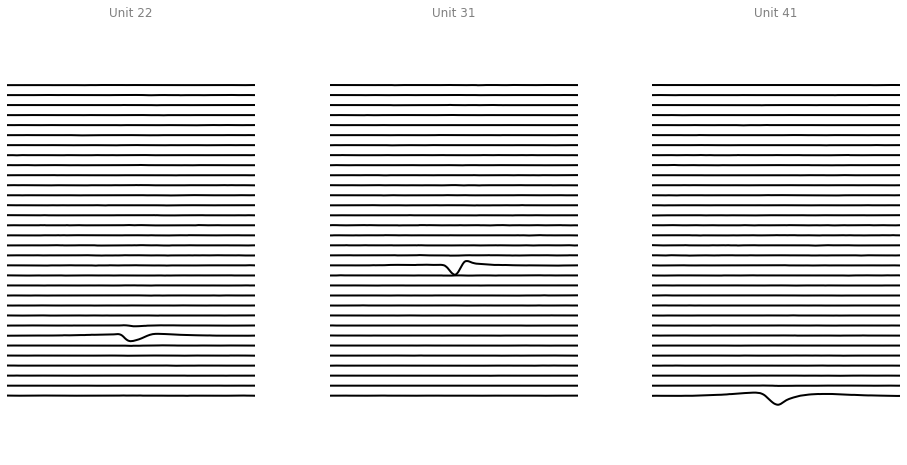

In [56]:
# Visualize spike template waverforms
fig = plt.figure(figsize=(16, 8))
sw.plot_unit_templates(rec_to_sort, sorting, unit_ids=[22, 31, 41], figure=fig)

In [28]:
# Extracellular features
ec_list = st.postprocessing.get_template_features_list()
print(f"Available EC features: {ec_list}")

In [29]:
# (optional) define subset of ec
ec_list = ["peak_to_valley", "halfwidth"]

# comput EC features
ec = st.postprocessing.compute_unit_template_features(
    rec_to_sort, 
    sorting,
    feature_names=ec_list, 
    as_dataframe=True
)

ec.head(10)

,peak_to_valley,halfwidth
2,0.000333,0.000267
3,0.000467,0.000300
4,0.000300,0.000267
5,0.000267,0.000233
6,0.000333,0.000300
7,0.000300,0.000267
8,0.000367,0.000233
9,0.000567,0.000333
10,0.000300,0.000267
11,0.000333,0.000233


# 5) Curating spike sorting outputs

### 5a) Manual curation with Phy

In [ ]:
# export to phy
phy_folder = dir_spikeinterface / 'phy' / 'klusta'
phy_folder.mkdir(parents=True, exist_ok=True)
print("Exporting to phy")

# here setting save_property_or_features to False so that Phy doesn't overwrite existing wfs, templates
st.postprocessing.export_to_phy(
    rec_to_sort, 
    sorting, 
    phy_folder, 
    save_property_or_features=False, 
    verbose=True
)

In [ ]:
# Reload curated output from phy
sorting_manual_curated = se.PhySortingExtractor(phy_folder, exclude_cluster_groups=["noise"])

### 5b) Automatic curation - quality metrics

You can automatically curate the spike sorting output using the quality metrics.

Ref: https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_4_curation.html

In [31]:
# Quality metrics
qc_list = st.validation.get_quality_metrics_list()
print(f"Available quality metrics: {qc_list}")

In [32]:
# (optional) define subset of qc
qc_list = ["snr", "isi_violation", "firing_rate"]

In [33]:
# compute quality metrics
qc = st.validation.compute_quality_metrics(
    sorting=sorting, 
    recording=rec_to_sort, 
    metric_names=qc_list, 
    as_dataframe=True
)

qc.head(10)

,firing_rate,isi_violation,snr
2,607.599808,0.388597,0.448472
3,1.924159,9.247160,5.412698
4,1.670238,4.772646,9.218921
5,0.174924,0.000000,5.622283
6,1.850804,6.107868,9.004913
7,19.619652,0.765891,5.092204
8,24.455442,0.973169,6.349205
9,2.014442,0.937429,5.915205
10,0.756121,3.326864,9.088893
11,23.958885,0.692518,5.992878


# 5) Curating spike sorting outputs

### 5a) Manual curation with Phy

In [ ]:
# export to phy
phy_folder = dir_spikeinterface / 'phy' / 'klusta'
phy_folder.mkdir(parents=True, exist_ok=True)
print("Exporting to phy")
# here setting save_property_or_features to False so that Phy doesn't overwrite existing wfs, templates
st.postprocessing.export_to_phy(rec_to_sort, sorting, phy_folder, save_property_or_features=False, 
                                verbose=True)

### Reload curated output from phy

In [34]:
# define curators and thresholds
firing_rate_threshold = 0.1
isi_violation_threshold = 0.6
snr_threshold = 4

In [35]:
num_frames = rec_to_sort.get_num_frames()

# firing rate threshold
sorting_curated = st.curation.threshold_firing_rates(
    sorting,
    duration_in_frames=num_frames,
    threshold=firing_rate_threshold, 
    threshold_sign='less'
)

# isi violation threshold
sorting_curated = st.curation.threshold_isi_violations(
    sorting_curated,
    duration_in_frames=num_frames,
    threshold=isi_violation_threshold, 
    threshold_sign='greater'
)

# isi violation threshold
sorting_curated = st.curation.threshold_snrs(
    sorting_curated,
    recording=rec_to_sort,
    threshold=snr_threshold, 
    threshold_sign='less'
)

In [36]:
print(f'Number of sorted units before curation: {len(sorting.get_unit_ids())}')
print(f'Number of sorted units after curation: {len(sorting_curated.get_unit_ids())}')

Number of sorted units before curation: 59
Number of sorted units after curation: 19


### 5c) Multisorting comparison - get consensus-based ensemble results
Ref: https://spikeinterface.readthedocs.io/en/latest/modules/comparison/plot_2_compare_multiple_sorters.html?highlight=get_agreement_sorting#consensus-based-method

Ensamble sorting among ['klusta', 'herdingspikes'] found: 5 units


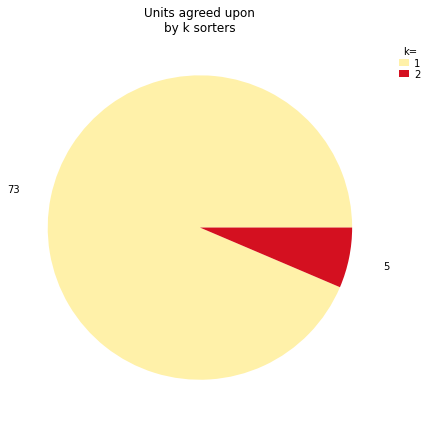

In [39]:
if len(sorter_list) > 1:       
    # run multisorting comparison
    mcmp = sc.compare_multiple_sorters(
        sorting_list=[s for s in sorting_outputs.values()], 
        name_list=sorter_list
    )
    
    # plot agreement results
    fig = plt.figure(figsize=(12, 7))
    w_agr = sw.plot_multicomp_agreement(
        multi_sorting_comparison=mcmp,
        plot_type='pie',  #'bar'
        figure=fig
    )
    
    # extract ensamble sorting
    sorting_ensemble = mcmp.get_agreement_sorting(minimum_agreement_count=2)
    
    print(f"Ensamble sorting among {sorter_list} found: {len(sorting_ensemble.get_unit_ids())} units")

# 6) Quick save to NWB

To complete the full conversion with other types of data and extended options, use a NWB Converter class.

NWBFile metadata reference: https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.NWBFile

In [ ]:
from nwb_conversion_tools.utils.spike_interface import write_recording, write_sorting

output_nwb = 'openephys_si_results.nwb'

# Add customized Metadata info - Optional
session_start_time = recording_0._fileobj.experiments[0].datetime
session_start_time_tzaware = pytz.timezone('EST').localize(session_start_time)

metadata = se.NwbRecordingExtractor.get_nwb_metadata(recording=rec_to_sort)
metadata['NWBFile'].update(
    session_start_time=session_start_time_tzaware,
    session_description='a detailed description of this experimental session...',
    institution='NYU',
    lab='Movshon lab',
    pharmacology='Description of drugs used',
    experimenter=['Person1', 'Person2'],
    keywords=['openephys', 'tutorial', 'etc']
)
metadata['Ecephys']['Device'][0].update(description='a detailed description of this device')

# Write voltage traces data
write_recording(
    recording=rec_to_sort,
    save_path=output_nwb,
    overwrite=True,
    metadata=metadata
)

# Write spiking data
write_sorting(
    sorting=sorting,
    save_path=output_nwb,
    overwrite=False
)

In [40]:
# Check NWB file with widgets
from pynwb import NWBFile, NWBHDF5IO
from nwbwidgets import nwb2widget

output_nwb = 'openephys_si_results.nwb'
io = NWBHDF5IO(output_nwb, 'r')
nwbfile = io.read()
nwb2widget(nwbfile)

In [41]:
io.close()

# 7) Include Expo trials with NWB conversion tools

In [42]:
from movshon_lab_to_nwb import MovshonExpoNWBConverter

In [43]:
# Source data
base_path = Path('/home/luiz/storage/taufferconsulting/client_ben/project_movshon/movshon_data/expo/exampledata/expo_openephys/m666l3#7')

expo_file = base_path / 'm666l3#7[ori16].xml'
ttl_file = base_path / 'openephys/100_ADC1.continuous'

source_data = dict(
    ExpoDataInterface=dict(
        expo_file=str(expo_file),
        ttl_file=str(ttl_file)
    )
)

# Initialize converter
converter = MovshonExpoNWBConverter(source_data=source_data)

# Conversion options
conversion_options = dict(
    ExpoDataInterface=dict(convert_expo=True)
)

converter.run_conversion(
    nwbfile_path=output_nwb, 
    overwrite=False,
    conversion_options=conversion_options
)

In [44]:
io = NWBHDF5IO(output_nwb, 'r')
nwbfile = io.read()
nwb2widget(nwbfile)

In [ ]:
io.close()

In [58]:
nwbfile.units

units pynwb.misc.Units at 0x140038459777232
Fields:
  colnames: ['quality' 'snr' 'halfwidth' 'template' 'max_channel' 'firing_rate'
 'peak_to_valley' 'isi_violation' 'group' 'spike_times' 'waveforms']
  columns: (
    quality <class 'hdmf.common.table.VectorData'>,
    snr <class 'hdmf.common.table.VectorData'>,
    halfwidth <class 'hdmf.common.table.VectorData'>,
    template <class 'hdmf.common.table.VectorData'>,
    max_channel <class 'hdmf.common.table.DynamicTableRegion'>,
    firing_rate <class 'hdmf.common.table.VectorData'>,
    peak_to_valley <class 'hdmf.common.table.VectorData'>,
    isi_violation <class 'hdmf.common.table.VectorData'>,
    group <class 'hdmf.common.table.VectorData'>,
    spike_times_index <class 'hdmf.common.table.VectorIndex'>,
    spike_times <class 'hdmf.common.table.VectorData'>,
    waveforms_index <class 'hdmf.common.table.VectorIndex'>,
    waveforms <class 'hdmf.common.table.VectorData'>
  )
  description: Autogenerated by NWBFile
  id: id <class